# IMPORT LIBRARIES

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import os
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
import requests
from io import StringIO

# UTILS FUNCTIONS

In [3]:
import my_functions

# LOADING MODELS FUNCTIONS

In [4]:
heading0_model = my_functions.heading0_model()


hitbool_model = my_functions.hitbool_model()


drift_model = my_functions.drift_model()


 ---- Part 1. Predicting Heading0 (measured in Degrees). ----  

 ---- Part 2. Predicting Hitbool. ----  

 ---- Part 3. Predicting Final Position. ----  



# WE CAN EXECUTE EACH MODEL SEPARATELY

### LOAD THE DATA

In [5]:
#####################################################################################################
    # INITIAL PART: DATA LOADING MET-LUNA
#####################################################################################################
folder_path = "./input_data"
start_word = "yme_weather_TIME_17-04_22-04"
df_met = my_functions.load_latest_file(folder_path, start_word)

In [6]:
#####################################################################################################
    # INITIAL PART: DATA LOADING STORMGEO
#####################################################################################################
folder_path = "./input_data"
start_word = "StormGeo_Yme_Field_2024041711"
df_stormgeo = my_functions.load_latest_file(folder_path, start_word)

In [7]:
#####################################################################################################
# INITIAL PART: DATA LOADING AIS (REAL VESSEL DATA)
#####################################################################################################
folder_path = "./input_data"
start_word = "AIS_HILDA KNUTSEN_msgtime_15-04_16-04_v0"
df_AIS = my_functions.load_latest_file(folder_path, start_word)

In [8]:
#####################################################################################################
# INITIAL PART: DATA LOADING FUGRO BOUY
#####################################################################################################
folder_path = "./input_data/"
start_word = "YMEMetoceanBuoyWind_29_Apr_2024.csv"
df_bouy = pd.read_csv(folder_path+start_word, sep=",", decimal=".", skiprows = 1)

In [9]:
df_met

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir
0,2024-04-17 12:00:00+00:00,8.2304,355,1.7,9.3,310,0.0,206.9
1,2024-04-17 13:00:00+00:00,7.7160,350,1.7,8.8,310,0.0,19.2
2,2024-04-17 14:00:00+00:00,7.7160,345,1.7,8.5,310,0.0,43.3
3,2024-04-17 15:00:00+00:00,6.6872,340,1.6,8.3,310,0.1,59.9
4,2024-04-17 16:00:00+00:00,6.6872,335,1.5,7.8,310,0.1,74.2
...,...,...,...,...,...,...,...,...
74,2024-04-21 18:00:00+00:00,0.5144,135,1.3,7.8,200,0.1,121.9
75,2024-04-21 21:00:00+00:00,1.5432,40,1.1,7.6,200,0.3,143.0
76,2024-04-22 00:00:00+00:00,2.5720,10,1.0,7.5,360,0.3,162.1
77,2024-04-22 03:00:00+00:00,3.0864,15,0.9,7.5,350,0.1,179.4


In [10]:
df_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TIME       79 non-null     object 
 1   WindSpeed  79 non-null     float64
 2   WindDir    79 non-null     int64  
 3   WaveHs     79 non-null     float64
 4   WaveTp     79 non-null     float64
 5   WaveDir    79 non-null     int64  
 6   CurrSpeed  79 non-null     float64
 7   CurrDir    79 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 5.1+ KB


In [11]:
df_stormgeo

,timestep,winddirection,windspeed,windspd_10m_gust,waveheight,peakperiod_1d,waveperiod,wavedirection,windwaveheight,windwave_period,windwave_dir,swellheight,swell_period,swell_direction,CUR_DIR_0m,CUR_SPD_0m,name,lat,lon
0,2024-04-17 11:00,5,7.8,10.1,1.61,8.8,4.6,328,0.89,4.0,4,1.33,8.0,314,343.0,0.04,Yme Field,57.821,4.554
1,2024-04-17 12:00,2,7.7,10.0,1.60,8.7,4.6,328,0.90,4.1,360,1.32,7.9,313,352.0,0.08,Yme Field,57.821,4.554
2,2024-04-17 13:00,357,7.5,9.8,1.57,8.5,4.6,327,0.89,4.1,356,1.30,7.8,312,359.0,0.12,Yme Field,57.821,4.554
3,2024-04-17 14:00,349,6.9,9.0,1.53,8.4,4.5,325,0.82,4.1,350,1.29,7.7,314,5.0,0.13,Yme Field,57.821,4.554
4,2024-04-17 15:00,341,7.2,9.4,1.49,8.3,4.5,323,0.84,4.2,344,1.23,7.7,313,11.0,0.14,Yme Field,57.821,4.554
5,2024-04-17 16:00,339,8.2,10.7,1.50,8.1,4.5,323,0.99,4.5,339,1.13,7.9,308,21.0,0.12,Yme Field,57.821,4.554
6,2024-04-17 17:00,338,8.4,10.9,1.53,7.6,4.4,323,1.08,4.6,338,1.09,7.9,306,42.0,0.09,Yme Field,57.821,4.554
7,2024-04-17 18:00,340,9.1,11.8,1.62,7.1,4.5,324,1.28,5.2,337,0.98,7.7,300,79.0,0.07,Yme Field,57.821,4.554
8,2024-04-17 19:00,338,9.4,12.5,1.73,6.9,4.6,325,1.47,5.7,336,0.92,7.4,292,118.0,0.07,Yme Field,57.821,4.554
9,2024-04-17 20:00,338,9.3,12.7,1.83,7.1,4.7,327,1.58,5.9,336,0.92,7.2,292,144.0,0.09,Yme Field,57.821,4.554


In [12]:
df_stormgeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestep          57 non-null     object 
 1   winddirection     57 non-null     int64  
 2   windspeed         57 non-null     float64
 3   windspd_10m_gust  57 non-null     float64
 4   waveheight        57 non-null     float64
 5   peakperiod_1d     57 non-null     float64
 6   waveperiod        57 non-null     float64
 7   wavedirection     57 non-null     int64  
 8   windwaveheight    57 non-null     float64
 9   windwave_period   57 non-null     float64
 10  windwave_dir      57 non-null     int64  
 11  swellheight       57 non-null     float64
 12  swell_period      57 non-null     float64
 13  swell_direction   57 non-null     int64  
 14  CUR_DIR_0m        47 non-null     float64
 15  CUR_SPD_0m        47 non-null     float64
 16  name              57 non-null     object 
 17 

In [13]:
df_AIS

,courseOverGround,latitude,longitude,name,rateOfTurn,shipType,speedOverGround,trueHeading,navigationalStatus,mmsi,msgtime
0,57.6,58.906453,4.895747,HILDA KNUTSEN,0,89,0.2,170,0,257895000,2024-04-16 07:19:50
1,75.2,58.906453,4.895707,HILDA KNUTSEN,0,89,0.6,170,0,257895000,2024-04-16 07:18:38
2,71.5,58.906447,4.895610,HILDA KNUTSEN,0,89,1.1,170,0,257895000,2024-04-16 07:17:29
3,265.1,58.906447,4.895567,HILDA KNUTSEN,0,89,0.4,170,0,257895000,2024-04-16 07:16:29
4,264.4,58.906447,4.895540,HILDA KNUTSEN,0,89,0.7,170,0,257895000,2024-04-16 07:15:29
...,...,...,...,...,...,...,...,...,...,...,...
1269,121.1,58.972887,4.829847,HILDA KNUTSEN,0,89,1.2,161,0,257895000,2024-04-15 07:25:20
1270,129.2,58.973147,4.829460,HILDA KNUTSEN,0,89,1.3,161,0,257895000,2024-04-15 07:24:20
1271,143.8,58.973387,4.829102,HILDA KNUTSEN,0,89,1.1,161,0,257895000,2024-04-15 07:23:20
1272,159.2,58.973673,4.828700,HILDA KNUTSEN,0,89,0.9,161,0,257895000,2024-04-15 07:22:08


In [14]:
df_AIS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   courseOverGround    1274 non-null   float64
 1   latitude            1274 non-null   float64
 2   longitude           1274 non-null   float64
 3   name                1274 non-null   object 
 4   rateOfTurn          1274 non-null   int64  
 5   shipType            1274 non-null   int64  
 6   speedOverGround     1274 non-null   float64
 7   trueHeading         1274 non-null   int64  
 8   navigationalStatus  1274 non-null   int64  
 9   mmsi                1274 non-null   int64  
 10  msgtime             1274 non-null   object 
dtypes: float64(4), int64(5), object(2)
memory usage: 109.6+ KB


In [15]:
df_bouy

,Timestamp,Offset to UTC,Buoy Position Northings (m - UTM 30N),Buoy Position Eastings (m - UTM 30N),Range from Nominal Position (m),Latitude,Longitude,Salinity @ 1m depth,Conductivity (S/m) @ 1m depth - 10 min,Sea Temperature (deg C) @ 1m depth - 10 min,...,Mean Wave Period (sea) (secs) - 30 min,Peak Wave Period (all) (secs) - 30 min,Buoy Lead Battery Voltage (Volts) - 60 mins,Buoy Lead Battery Charging Rate (Ah) - 60 mins,Buoy Lead Battery Discharging Rate (Ah) - 60 mins,Buoy Lithium Battery Voltage (Volts) - 60 mins,Buoy Lithium Battery Discharging Rate (Ah) - 60 mins,Inspirer Wind Speed (kts) - 1 min,Inspirer Wind Gust (kts) - 1 min,Inspirer Wind Direction (deg T) - 1 min
0,2024/04/28T00:00:00,00:00,6409910.0,591107.0,113.81,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.94,0.0,0.36,14.45,138.0,27.16,28.34,101.07
1,2024/04/28T00:01:00,00:00,6409910.0,591107.0,113.81,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.31,28.73,99.68
2,2024/04/28T00:02:00,00:00,6409910.0,591107.0,113.81,57.82,4.53,34.65,35.43,7.63,...,4.96,6.25,NaN,NaN,NaN,NaN,NaN,25.85,27.34,97.50
3,2024/04/28T00:03:00,00:00,6409902.0,591099.0,113.81,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.21,25.89,98.78
4,2024/04/28T00:04:00,00:00,6409902.0,591099.0,116.11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.03,25.98,97.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67675,2024/04/29T07:35:00,00:00,6409949.0,591135.0,123.82,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.29,31.30,199.18
67676,2024/04/29T07:36:00,00:00,6409949.0,591135.0,123.82,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.77,32.16,199.35
67677,2024/04/29T07:37:00,00:00,6409949.0,591135.0,123.82,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.17,33.01,199.06
67678,2024/04/29T07:38:00,00:00,6409949.0,591135.0,123.82,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.59,32.62,199.10


In [16]:
df_bouy.describe()

,Buoy Position Northings (m - UTM 30N),Buoy Position Eastings (m - UTM 30N),Range from Nominal Position (m),Latitude,Longitude,Salinity @ 1m depth,Conductivity (S/m) @ 1m depth - 10 min,Sea Temperature (deg C) @ 1m depth - 10 min,Current Direction (deg T) @ 6m depth - 10 min,Current Direction (deg T) @ 10m depth - 10 min,...,Mean Wave Period (swell) (secs) - 30 min,Mean Wave Period (sea) (secs) - 30 min,Peak Wave Period (all) (secs) - 30 min,Buoy Lead Battery Voltage (Volts) - 60 mins,Buoy Lead Battery Charging Rate (Ah) - 60 mins,Buoy Lead Battery Discharging Rate (Ah) - 60 mins,Buoy Lithium Battery Voltage (Volts) - 60 mins,Buoy Lithium Battery Discharging Rate (Ah) - 60 mins,Inspirer Wind Speed (kts) - 1 min,Inspirer Wind Gust (kts) - 1 min
count,6.744500e+04,67445.000000,67445.000000,6.721000e+03,6.721000e+03,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,...,6721.000000,6721.000000,6721.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.0,67680.000000,67680.000000
mean,6.409928e+06,591121.839128,125.998275,5.782000e+01,4.530000e+00,34.784537,35.477991,7.520333,281.989414,281.183763,...,14.061644,5.554745,7.486758,13.160629,0.168475,0.204415,14.433041,138.0,38.088687,40.582113
std,3.221519e+01,42.372712,13.933457,5.755824e-12,3.846099e-13,0.063403,0.037006,0.047406,76.008595,75.901210,...,1.929439,0.412624,0.747066,0.374133,0.246696,0.134728,0.011865,0.0,4.527611,4.841817
min,6.409807e+06,591072.000000,75.240000,5.782000e+01,4.530000e+00,34.650000,35.380000,7.440000,16.680000,1.830000,...,11.410000,4.690000,5.860000,12.750000,0.000000,0.040000,14.420000,138.0,24.210000,25.870000
25%,6.409920e+06,591093.000000,123.150000,5.782000e+01,4.530000e+00,34.770000,35.480000,7.470000,278.280000,277.920000,...,12.520000,5.230000,6.840000,12.880000,0.000000,0.070000,14.420000,138.0,34.650000,36.760000
50%,6.409937e+06,591112.000000,131.530000,5.782000e+01,4.530000e+00,34.800000,35.480000,7.530000,312.210000,310.090000,...,13.400000,5.590000,7.520000,13.030000,0.070000,0.160000,14.430000,138.0,37.850000,40.460000
75%,6.409948e+06,591127.000000,134.350000,5.782000e+01,4.530000e+00,34.840000,35.480000,7.560000,327.060000,327.420000,...,15.740000,5.940000,8.110000,13.660000,0.290000,0.360000,14.440000,138.0,41.460000,44.490000
max,6.409965e+06,591231.000000,141.330000,5.782000e+01,4.530000e+00,34.880000,35.530000,7.630000,352.870000,352.520000,...,19.320000,6.250000,8.690000,13.970000,0.870000,0.370000,14.460000,138.0,49.580000,53.850000


## WE NEED TO TRANSFORM STORMGEO DATA TO MATCH MET FORMAT

In [17]:
# Columns to keep
columns_keep = ["timestep", "windspeed", "winddirection", "waveheight", "waveperiod", "wavedirection", "CUR_SPD_0m", "CUR_DIR_0m"]
# Use a certain columns_to_remove list
columns_to_remove = [col for col in df_stormgeo.columns if col not in columns_keep]

# Add additional columns for the else case if needed
df_stormgeo = df_stormgeo.drop(columns=columns_to_remove)[columns_keep]
column_mapping = {df_stormgeo.columns[i]: ["TIME", "WindSpeed", "WindDir", "WaveHs", "WaveTp", "WaveDir", "CurrSpeed", "CurrDir"][i] for i in range(len(df_met.columns))}
df_original = df_stormgeo.rename(columns=column_mapping)

In [18]:
df_stormgeo = df_original

## NOW WE CAN FILTER THE DATAFRAMES TO GET A SPECIFIC TIME RANGE

In [19]:
# INPUT HERE DESIRED DAY RANGE
# INPUT HERE DESIRED HOUR RANGE
day_range = [17,23]
hour_range = [12, 23]

df_stormgeo_filt = my_functions.time_frame(df_stormgeo, "TIME", day_range = day_range, hour_range = hour_range)
df_met_filt = my_functions.time_frame(df_met, "TIME", day_range = day_range, hour_range = hour_range)
#df_AIS_filt = my_functions.time_frame(df_AIS, "msgtime", day_range = day_range, hour_range = hour_range)

In [20]:
df_stormgeo_filt

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir
2,2024-04-17 13:00:00,7.5,357,1.57,4.6,327,0.12,359.0
3,2024-04-17 14:00:00,6.9,349,1.53,4.5,325,0.13,5.0
4,2024-04-17 15:00:00,7.2,341,1.49,4.5,323,0.14,11.0
5,2024-04-17 16:00:00,8.2,339,1.50,4.5,323,0.12,21.0
6,2024-04-17 17:00:00,8.4,338,1.53,4.4,323,0.09,42.0
7,2024-04-17 18:00:00,9.1,340,1.62,4.5,324,0.07,79.0
8,2024-04-17 19:00:00,9.4,338,1.73,4.6,325,0.07,118.0
9,2024-04-17 20:00:00,9.3,338,1.83,4.7,327,0.09,144.0
10,2024-04-17 21:00:00,8.9,339,1.91,4.8,328,0.09,162.0
11,2024-04-17 22:00:00,8.9,336,1.98,4.9,329,0.08,180.0


In [21]:
df_met_filt

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir
1,2024-04-17 13:00:00+00:00,7.7160,350,1.7,8.8,310,0.0,19.2
2,2024-04-17 14:00:00+00:00,7.7160,345,1.7,8.5,310,0.0,43.3
3,2024-04-17 15:00:00+00:00,6.6872,340,1.6,8.3,310,0.1,59.9
4,2024-04-17 16:00:00+00:00,6.6872,335,1.5,7.8,310,0.1,74.2
5,2024-04-17 17:00:00+00:00,6.6872,340,1.4,7.6,300,0.1,90.9
6,2024-04-17 18:00:00+00:00,7.7160,340,1.4,9.0,300,0.1,118.0
7,2024-04-17 19:00:00+00:00,7.7160,335,1.4,9.0,300,0.1,139.0
8,2024-04-17 20:00:00+00:00,8.2304,335,1.5,9.0,310,0.1,149.8
9,2024-04-17 21:00:00+00:00,8.7448,340,1.6,8.8,310,0.1,155.6
10,2024-04-17 22:00:00+00:00,8.2304,340,1.8,8.4,320,0.1,159.0


## NOW LET'S TRANSFORM THE AIS DATA

In [22]:
day = df_met_filt["TIME"].dt.day[1]
df_AIS['msgtime'] = pd.to_datetime(df_AIS['msgtime'])
df_AIS = df_AIS[df_AIS['msgtime'].dt.day == day]
hours_list = df_met_filt["TIME"].dt.hour.tolist()
filtered_rows = []
# Iterate over each condition
for condition in hours_list:
    # Filter DataFrame based on condition
    conditioned_df = df_AIS[df_AIS['msgtime'].dt.hour == condition]
    
    # Select the first row matching the condition
    if not conditioned_df.empty:
        first_row = conditioned_df.iloc[0]
        filtered_rows.append(first_row)


        print(f"First row for condition '{condition}':\n{first_row}\n")
    else:
        print(f"No rows found for condition '{condition}'\n")

if conditioned_df.empty:
    AIS_df_filt = conditioned_df
else:
    # Create a new DataFrame from the list of filtered rows
    conditioned_df = pd.DataFrame(filtered_rows)
    # Reset index of the new DataFrame
    conditioned_df.reset_index(drop=True, inplace=True)
    conditioned_df["trueHeading"] = conditioned_df["trueHeading"] - 1.3
    AIS_df_filt = conditioned_df

No rows found for condition '13'

No rows found for condition '14'

No rows found for condition '15'

No rows found for condition '16'

No rows found for condition '17'

No rows found for condition '18'

No rows found for condition '19'

No rows found for condition '20'

No rows found for condition '21'

No rows found for condition '22'

No rows found for condition '23'

No rows found for condition '13'

No rows found for condition '14'

No rows found for condition '15'

No rows found for condition '16'

No rows found for condition '17'

No rows found for condition '18'

No rows found for condition '19'

No rows found for condition '20'

No rows found for condition '21'

No rows found for condition '22'

No rows found for condition '23'

No rows found for condition '13'

No rows found for condition '14'

No rows found for condition '15'

No rows found for condition '16'

No rows found for condition '17'

No rows found for condition '18'

No rows found for condition '19'

No rows found 

In [23]:
AIS_df_filt

,courseOverGround,latitude,longitude,name,rateOfTurn,shipType,speedOverGround,trueHeading,navigationalStatus,mmsi,msgtime


## AND NOW LET'S TRANSFORM THE BOUY DATA

In [24]:
df_met_filt["TIME"].dt.day

1     17
2     17
3     17
4     17
5     17
6     17
7     17
8     17
9     17
10    17
11    17
25    18
26    18
27    18
28    18
29    18
30    18
31    18
32    18
33    18
34    18
35    18
49    19
50    19
51    19
52    19
53    19
54    19
55    19
56    19
57    19
58    19
59    19
65    20
66    20
67    20
73    21
74    21
75    21
Name: TIME, dtype: int32

In [25]:
# Columns to keep
columns_keep = ['Timestamp',"Current Direction (deg T) @  6m depth - 10 min", "Mean Wave Direction (all) (deg T) - 30 min", " Inspirer Wind Direction (deg T) - 1 min", "Current Speed (kts) @  6m depth - 10 min", "Signifcant Wave Height (all) (m) - 30 min", "Mean Wave Period (all) (secs) - 30 min", " Inspirer Wind Speed (kts) - 1 min"]
# Use a certain columns_to_remove list
columns_to_remove = [col for col in df_bouy.columns if col not in columns_keep]

# Add additional columns for the else case if needed
df_bouy_filt = df_bouy.drop(columns=columns_to_remove)[columns_keep]
#df_bouy_filt.rename(columns={'Timestamp': "TIME", 'Current Direction (deg T) @  6m depth - 10 min': 'CurrDir', 'Mean Wave Direction (all) (deg T) - 30 min': 'WaveDir', 'Inspirer Wind Direction (deg T) - 1 min': 'WindDir', 'Current Speed (kts) @  6m depth - 10 min': 'CurrSpeed', 'Signifcant Wave Height (all) (m) - 30 min': 'WaveHs', "Mean Wave Period (all) (secs) - 30 min": "WaveTp", 'Inspirer Wind Speed (kts) - 1 min': 'WindSpeed'})
df_bouy_filt = df_bouy_filt.rename(columns={df_bouy_filt.columns[0]: 'TIME',df_bouy_filt.columns[1]: 'CurrDir', df_bouy_filt.columns[2]: 'WaveDir', df_bouy_filt.columns[3]: 'WindDir', df_bouy_filt.columns[4]: 'CurrSpeed', df_bouy_filt.columns[5]: 'WaveHs', df_bouy_filt.columns[6]: 'WaveTp', df_bouy_filt.columns[7]: 'WindSpeed'})

# Define the new order of columns
new_column_order = df_met.columns.tolist()
# df_bouy_filt["WaveTp"] = 0

# Reindex the DataFrame with the new column order
df_bouy_filt = df_bouy_filt.reindex(columns=new_column_order)

# Now we filter the DataFrame to match the hours
df_bouy_filt['TIME'] = pd.to_datetime(df_bouy_filt['TIME'])
day = df_met_filt["TIME"].dt.day[1]
df_bouy_transf = df_bouy_filt[df_bouy_filt['TIME'].dt.day == day]
df_bouy_transf

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir


In [26]:
df_bouy_transf.describe()

,TIME,WindSpeed,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir
count,0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
day = df_met_filt["TIME"].dt.day[1]
df_bouy_filt = df_bouy_transf[df_bouy_filt['TIME'].dt.day == day]
filtered_rows = []
# Iterate over each condition
for condition in hours_list:
    # Filter DataFrame based on condition
    filtered_df = df_bouy_filt[df_bouy_filt['TIME'].dt.hour == condition]
    conditioned_df = filtered_df[filtered_df.notna().all(axis=1)]
    
    # Select the first row matching the condition
    if not conditioned_df.empty:
        first_row = conditioned_df.iloc[0]
        filtered_rows.append(first_row)


        print(f"First row for condition '{condition}':\n{first_row}\n")
    else:
        print(f"No rows found for condition '{condition}'\n")

# Create a new DataFrame from the list of filtered rows
conditioned_df = pd.DataFrame(filtered_rows)

# Reset index of the new DataFrame
conditioned_df.reset_index(drop=True, inplace=True)
df_bouy_filt = conditioned_df

No rows found for condition '13'

No rows found for condition '14'

No rows found for condition '15'

No rows found for condition '16'

No rows found for condition '17'

No rows found for condition '18'

No rows found for condition '19'

No rows found for condition '20'

No rows found for condition '21'

No rows found for condition '22'

No rows found for condition '23'

No rows found for condition '13'

No rows found for condition '14'

No rows found for condition '15'

No rows found for condition '16'

No rows found for condition '17'

No rows found for condition '18'

No rows found for condition '19'

No rows found for condition '20'

No rows found for condition '21'

No rows found for condition '22'

No rows found for condition '23'

No rows found for condition '13'

No rows found for condition '14'

No rows found for condition '15'

No rows found for condition '16'

No rows found for condition '17'

No rows found for condition '18'

No rows found for condition '19'

No rows found 

In [28]:
df_bouy_filt

""


In [29]:
if df_bouy_filt.empty:
    df_bouy_filt = df_bouy_transf.iloc[:0,:].copy()
else:
    df_bouy_filt["WindSpeed"] = pd.to_numeric(df_bouy_filt["WindSpeed"], errors='coerce')
    df_bouy_filt["WindDir"] = pd.to_numeric(df_bouy_filt["WindDir"], errors='coerce')  # 'coerce' will replace non-numeric values with NaN
    df_bouy_filt["CurrSpeed"] = pd.to_numeric(df_bouy_filt["CurrSpeed"], errors='coerce')  # 'coerce' will replace non-numeric values with NaN
    df_bouy_filt["CurrDir"] = pd.to_numeric(df_bouy_filt["CurrDir"], errors='coerce')  # 'coerce' will replace non-numeric values with NaN
    df_bouy_filt["WaveHs"] = pd.to_numeric(df_bouy_filt["WaveHs"], errors='coerce')  # 'coerce' will replace non-numeric values with NaN
    df_bouy_filt["WaveTp"] = pd.to_numeric(df_bouy_filt["WaveTp"], errors='coerce')
    
    df_bouy_filt["heading0"] = 0
    # df_bouy_filt["WindDir"] = df_bouy_filt["WindDir"] + 180
    # df_bouy_filt["WindDir"] = df_bouy_filt["WaveDir"] + 180
    df_bouy_filt["WindSpeed"] *= 0.5144
    df_bouy_filt["CurrSpeed"] *= 0.5144
    df_bouy_filt

In [30]:
df_bouy_filt

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir


In [31]:
if df_bouy_transf.empty:
    df_bouy_empty = df_bouy_transf
else:
    df_bouy_empty = df_bouy_filt.iloc[:0,:].copy()

In [32]:
df_bouy_empty

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir


## TRANSFORM WEATHER DATAFRAMES INTO DESIRED TABLE FORMAT

In [33]:
len(df_bouy_empty)

0

In [34]:
# FIRST THE ORIGINAL WEATHER DATAFRAMES
if df_bouy_filt.empty:
    df_met_transf = my_functions.transform_dir_variables(df_met_filt, df_bouy_empty)
    df_stormgeo_transf = my_functions.transform_dir_variables(df_stormgeo_filt, df_bouy_empty)
else:
    df_met_transf = my_functions.transform_dir_variables(df_met_filt, df_bouy_empty)
    df_stormgeo_transf = my_functions.transform_dir_variables(df_stormgeo_filt, df_bouy_empty)
    df_bouy_transf = my_functions.transform_dir_variables(df_bouy_filt, df_bouy_empty)

In [35]:
df_met_transf

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir
1,2024-04-17 13:00:00+00:00,7.7160,171.3,1.7,8.8,131.3,0.0,20.5
2,2024-04-17 14:00:00+00:00,7.7160,166.3,1.7,8.5,131.3,0.0,44.6
3,2024-04-17 15:00:00+00:00,6.6872,161.3,1.6,8.3,131.3,0.1,61.2
4,2024-04-17 16:00:00+00:00,6.6872,156.3,1.5,7.8,131.3,0.1,75.5
5,2024-04-17 17:00:00+00:00,6.6872,161.3,1.4,7.6,121.3,0.1,92.2
6,2024-04-17 18:00:00+00:00,7.7160,161.3,1.4,9.0,121.3,0.1,119.3
7,2024-04-17 19:00:00+00:00,7.7160,156.3,1.4,9.0,121.3,0.1,140.3
8,2024-04-17 20:00:00+00:00,8.2304,156.3,1.5,9.0,131.3,0.1,151.1
9,2024-04-17 21:00:00+00:00,8.7448,161.3,1.6,8.8,131.3,0.1,156.9
10,2024-04-17 22:00:00+00:00,8.2304,161.3,1.8,8.4,141.3,0.1,160.3


In [36]:
if df_bouy_filt.empty:
    df_predict_met = my_functions.process_input_file(df_met_transf)
    df_predict_storm = my_functions.process_input_file(df_stormgeo_transf)

else:
    df_predict_met = my_functions.process_input_file(df_met_transf)
    df_predict_storm = my_functions.process_input_file(df_stormgeo_transf)
    df_predict_bouy = my_functions.process_input_file(df_bouy_transf)

 Encoding angular variable ---> WindDir
 Encoded angular variable ---> WindDir
 Encoding angular variable ---> WaveDir
 Encoded angular variable ---> WaveDir
 Encoding angular variable ---> CurrDir
 Encoded angular variable ---> CurrDir
Attempting to predict 39 events using Index(['TIME', 'WindSpeed', 'WindDir', 'WaveHs', 'WaveTp', 'WaveDir',
       'CurrSpeed', 'CurrDir', 'cos_WindDir', 'sin_WindDir', 'cos_WaveDir',
       'sin_WaveDir', 'cos_CurrDir', 'sin_CurrDir'],
      dtype='object')
 Encoding angular variable ---> WindDir
 Encoded angular variable ---> WindDir
 Encoding angular variable ---> WaveDir
 Encoded angular variable ---> WaveDir
 Encoding angular variable ---> CurrDir
 Encoded angular variable ---> CurrDir
Attempting to predict 20 events using Index(['TIME', 'WindSpeed', 'WindDir', 'WaveHs', 'WaveTp', 'WaveDir',
       'CurrSpeed', 'CurrDir', 'cos_WindDir', 'sin_WindDir', 'cos_WaveDir',
       'sin_WaveDir', 'cos_CurrDir', 'sin_CurrDir'],
      dtype='object')


In [37]:
df_predict_storm

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir,cos_WindDir,sin_WindDir,cos_WaveDir,sin_WaveDir,cos_CurrDir,sin_CurrDir
2,2024-04-17 13:00:00,7.5,178.3,1.57,4.6,148.3,0.12,360.3,-0.999560,0.029666,-0.850811,0.525472,0.999986,0.005236
3,2024-04-17 14:00:00,6.9,170.3,1.53,4.5,146.3,0.13,6.3,-0.985703,0.168489,-0.831954,0.554844,0.993961,0.109734
4,2024-04-17 15:00:00,7.2,162.3,1.49,4.5,144.3,0.14,12.3,-0.952661,0.304033,-0.812084,0.583541,0.977046,0.213030
5,2024-04-17 16:00:00,8.2,160.3,1.50,4.5,144.3,0.12,22.3,-0.941471,0.337095,-0.812084,0.583541,0.925210,0.379456
6,2024-04-17 17:00:00,8.4,159.3,1.53,4.4,144.3,0.09,43.3,-0.935444,0.353475,-0.812084,0.583541,0.727773,0.685818
7,2024-04-17 18:00:00,9.1,161.3,1.62,4.5,145.3,0.07,80.3,-0.947210,0.320613,-0.822144,0.569280,0.168489,0.985703
8,2024-04-17 19:00:00,9.4,159.3,1.73,4.6,146.3,0.07,119.3,-0.935444,0.353475,-0.831954,0.554844,-0.489382,0.872069
9,2024-04-17 20:00:00,9.3,159.3,1.83,4.7,148.3,0.09,145.3,-0.935444,0.353475,-0.850811,0.525472,-0.822144,0.569280
10,2024-04-17 21:00:00,8.9,160.3,1.91,4.8,149.3,0.09,163.3,-0.941471,0.337095,-0.859852,0.510543,-0.957822,0.287361
11,2024-04-17 22:00:00,8.9,157.3,1.98,4.9,150.3,0.08,181.3,-0.922538,0.385906,-0.868632,0.495459,-0.999743,-0.022687


In [38]:
df_predict_met

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir,cos_WindDir,sin_WindDir,cos_WaveDir,sin_WaveDir,cos_CurrDir,sin_CurrDir
1,2024-04-17 13:00:00+00:00,7.7160,171.3,1.7,8.8,131.3,0.0,20.5,-0.988494,0.151261,-0.660002,0.751264,0.936672,0.350207
2,2024-04-17 14:00:00+00:00,7.7160,166.3,1.7,8.5,131.3,0.0,44.6,-0.971549,0.236838,-0.660002,0.751264,0.712026,0.702153
3,2024-04-17 15:00:00+00:00,6.6872,161.3,1.6,8.3,131.3,0.1,61.2,-0.947210,0.320613,-0.660002,0.751264,0.481754,0.876307
4,2024-04-17 16:00:00+00:00,6.6872,156.3,1.5,7.8,131.3,0.1,75.5,-0.915663,0.401948,-0.660002,0.751264,0.250380,0.968148
5,2024-04-17 17:00:00+00:00,6.6872,161.3,1.4,7.6,121.3,0.1,92.2,-0.947210,0.320613,-0.519519,0.854459,-0.038388,0.999263
6,2024-04-17 18:00:00+00:00,7.7160,161.3,1.4,9.0,121.3,0.1,119.3,-0.947210,0.320613,-0.519519,0.854459,-0.489382,0.872069
7,2024-04-17 19:00:00+00:00,7.7160,156.3,1.4,9.0,121.3,0.1,140.3,-0.915663,0.401948,-0.519519,0.854459,-0.769400,0.638768
8,2024-04-17 20:00:00+00:00,8.2304,156.3,1.5,9.0,131.3,0.1,151.1,-0.915663,0.401948,-0.660002,0.751264,-0.875465,0.483282
9,2024-04-17 21:00:00+00:00,8.7448,161.3,1.6,8.8,131.3,0.1,156.9,-0.947210,0.320613,-0.660002,0.751264,-0.919821,0.392337
10,2024-04-17 22:00:00+00:00,8.2304,161.3,1.8,8.4,141.3,0.1,160.3,-0.947210,0.320613,-0.780430,0.625243,-0.941471,0.337095


In [39]:
if df_bouy_filt.empty:
    df_list_test = [df_predict_met, df_predict_storm]
else:
    df_list_test = [df_predict_met, df_predict_storm, df_predict_bouy]

In [40]:
df_predict_storm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2 to 50
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TIME         20 non-null     datetime64[ns]
 1   WindSpeed    20 non-null     float64       
 2   WindDir      20 non-null     float64       
 3   WaveHs       20 non-null     float64       
 4   WaveTp       20 non-null     float64       
 5   WaveDir      20 non-null     float64       
 6   CurrSpeed    19 non-null     float64       
 7   CurrDir      19 non-null     float64       
 8   cos_WindDir  20 non-null     float64       
 9   sin_WindDir  20 non-null     float64       
 10  cos_WaveDir  20 non-null     float64       
 11  sin_WaveDir  20 non-null     float64       
 12  cos_CurrDir  19 non-null     float64       
 13  sin_CurrDir  19 non-null     float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 2.3 KB


In [41]:
df_predict_met.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 1 to 75
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   TIME         39 non-null     datetime64[ns, UTC]
 1   WindSpeed    39 non-null     float64            
 2   WindDir      39 non-null     float64            
 3   WaveHs       39 non-null     float64            
 4   WaveTp       39 non-null     float64            
 5   WaveDir      39 non-null     float64            
 6   CurrSpeed    39 non-null     float64            
 7   CurrDir      39 non-null     float64            
 8   cos_WindDir  39 non-null     float64            
 9   sin_WindDir  39 non-null     float64            
 10  cos_WaveDir  39 non-null     float64            
 11  sin_WaveDir  39 non-null     float64            
 12  cos_CurrDir  39 non-null     float64            
 13  sin_CurrDir  39 non-null     float64            
dtypes: datetime64[ns, UTC](1), float6

## FIRST MODEL: HEADING0

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [42]:
# FIRST FOR THE ORIGINAL DAATA
df_predict_list = my_functions.heading0_report(df_list_test,heading0_model)
if df_bouy_filt.empty:
    df_met_plot, df_storm_plot = df_predict_list[0], df_predict_list[1]
else:
    df_met_plot, df_storm_plot, df_bouy_plot = df_predict_list[0], df_predict_list[1], df_predict_list[2]

 For timestamp 2024-04-17 13:00:00+00:00 heading predicted is 328.68º
 For timestamp 2024-04-17 14:00:00+00:00 heading predicted is 324.84º
 For timestamp 2024-04-17 15:00:00+00:00 heading predicted is 320.66º
 For timestamp 2024-04-17 16:00:00+00:00 heading predicted is 319.42º
 For timestamp 2024-04-17 17:00:00+00:00 heading predicted is 317.26º
 For timestamp 2024-04-17 18:00:00+00:00 heading predicted is 319.04º
 For timestamp 2024-04-17 19:00:00+00:00 heading predicted is 317.06º
 For timestamp 2024-04-17 20:00:00+00:00 heading predicted is 322.54º
 For timestamp 2024-04-17 21:00:00+00:00 heading predicted is 324.13º
 For timestamp 2024-04-17 22:00:00+00:00 heading predicted is 332.97º
 For timestamp 2024-04-17 23:00:00+00:00 heading predicted is 333.46º
 For timestamp 2024-04-18 13:00:00+00:00 heading predicted is 318.36º
 For timestamp 2024-04-18 14:00:00+00:00 heading predicted is 291.41º
 For timestamp 2024-04-18 15:00:00+00:00 heading predicted is 279.15º
 For timestamp 2024-

In [43]:
df_met_plot

,TIME,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir,cos_WindDir,sin_WindDir,cos_WaveDir,sin_WaveDir,cos_CurrDir,sin_CurrDir,sin_heading0,cos_heading0,heading0
1,2024-04-17 13:00:00+00:00,7.7160,171.3,1.7,8.8,131.3,0.0,20.5,-0.988494,0.151261,-0.660002,0.751264,0.936672,0.350207,-0.503488,0.827307,328.68
2,2024-04-17 14:00:00+00:00,7.7160,166.3,1.7,8.5,131.3,0.0,44.6,-0.971549,0.236838,-0.660002,0.751264,0.712026,0.702153,-0.563632,0.800186,324.84
3,2024-04-17 15:00:00+00:00,6.6872,161.3,1.6,8.3,131.3,0.1,61.2,-0.947210,0.320613,-0.660002,0.751264,0.481754,0.876307,-0.632868,0.772206,320.66
4,2024-04-17 16:00:00+00:00,6.6872,156.3,1.5,7.8,131.3,0.1,75.5,-0.915663,0.401948,-0.660002,0.751264,0.250380,0.968148,-0.648120,0.756598,319.42
5,2024-04-17 17:00:00+00:00,6.6872,161.3,1.4,7.6,121.3,0.1,92.2,-0.947210,0.320613,-0.519519,0.854459,-0.038388,0.999263,-0.682554,0.738512,317.26
6,2024-04-17 18:00:00+00:00,7.7160,161.3,1.4,9.0,121.3,0.1,119.3,-0.947210,0.320613,-0.519519,0.854459,-0.489382,0.872069,-0.636881,0.733791,319.04
7,2024-04-17 19:00:00+00:00,7.7160,156.3,1.4,9.0,121.3,0.1,140.3,-0.915663,0.401948,-0.519519,0.854459,-0.769400,0.638768,-0.678689,0.729337,317.06
8,2024-04-17 20:00:00+00:00,8.2304,156.3,1.5,9.0,131.3,0.1,151.1,-0.915663,0.401948,-0.660002,0.751264,-0.875465,0.483282,-0.604931,0.789541,322.54
9,2024-04-17 21:00:00+00:00,8.7448,161.3,1.6,8.8,131.3,0.1,156.9,-0.947210,0.320613,-0.660002,0.751264,-0.919821,0.392337,-0.576920,0.797895,324.13
10,2024-04-17 22:00:00+00:00,8.2304,161.3,1.8,8.4,141.3,0.1,160.3,-0.947210,0.320613,-0.780430,0.625243,-0.941471,0.337095,-0.451018,0.883997,332.97


In [49]:
if AIS_df_filt.empty:
    AIS_df_empty = AIS_df_filt
else:
    AIS_df_empty = pd.DataFrame(data=0, columns=AIS_df_filt.columns, index=AIS_df_filt.index).iloc[[0]]

## PLOT SLS CIRCLE

The AIS dataframe is empty


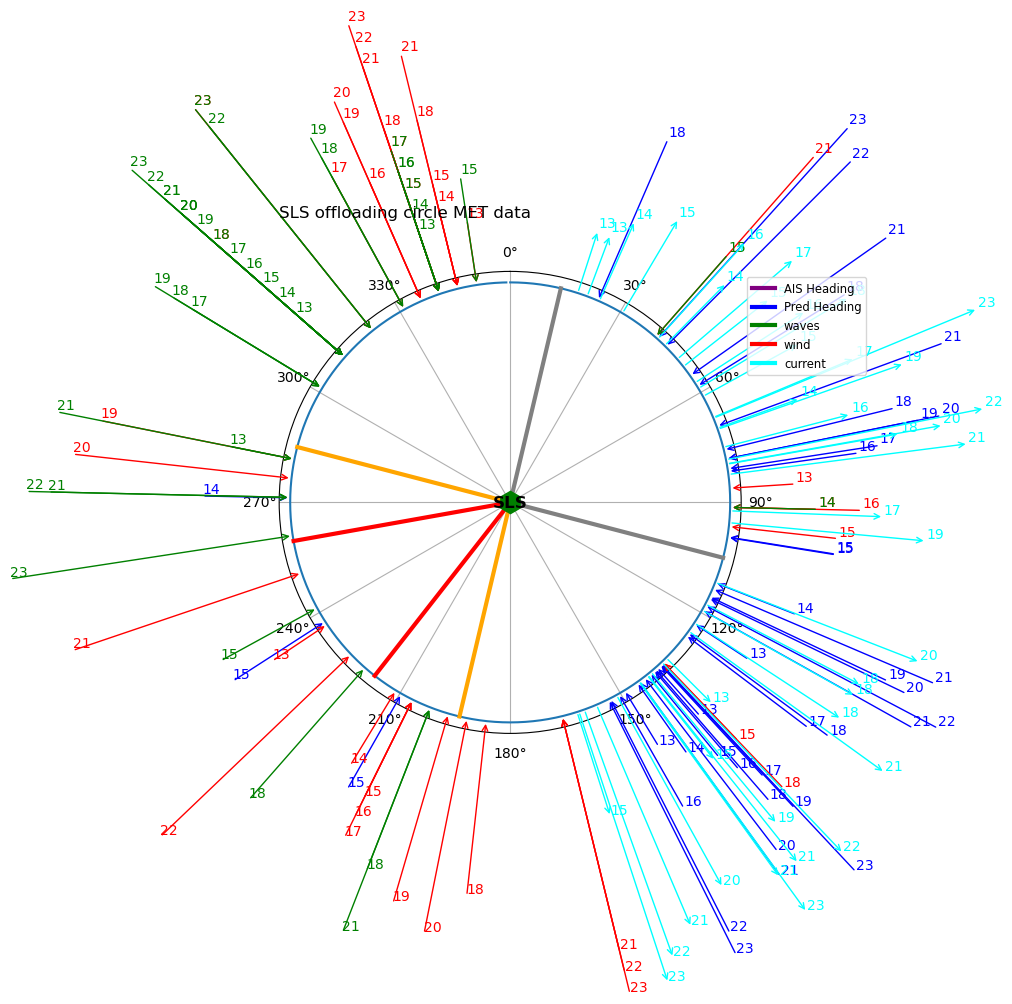

In [50]:
if AIS_df_filt.empty:
    my_functions.sls_diagram_plot(df_predict_list[0], AIS_df_empty, "SLS offloading circle MET data")
else:
    my_functions.sls_diagram_plot(df_predict_list[0], AIS_df_filt, "SLS offloading circle MET data")

In [ ]:
if AIS_df_filt.empty:
    my_functions.sls_diagram_plot(df_predict_list[1], AIS_df_empty, "SLS offloading circle StormGeo data")
else:
    my_functions.sls_diagram_plot(df_predict_list[1], AIS_df_filt, "SLS offloading circle StormGeo data")

In [ ]:
if df_bouy_filt.empty:
    pass
else:
    my_functions.sls_diagram_plot(df_predict_list[2], AIS_df_filt, "SLS offloading circle Bouy data")

In [ ]:
df_predict_list[0] # MET weather

In [ ]:
df_predict_list[1] # StormGeo weather

In [ ]:
AIS_df_filt

# NOW LET'S ADJUST THE DATA USING BOUY CORRECTED DATA AND PLOT AGAIN

In [ ]:
df_met_filt

In [ ]:
df_bouy_filt

In [ ]:
df_1 = df_bouy_filt.copy()
df_2 = df_met_filt.copy()


    
df_1_row = df_1.loc[df_1['TIME'] == df_1['TIME'].max()]
df_2_row = df_2.iloc[[0]]
print("The timestamp of the Bouy data ", df_1_row['TIME'])
print("The timestamp of the weather data ", df_2_row['TIME'])

df_adjust_values = pd.DataFrame(data=0, columns=df_2.columns, index=df_2.index).iloc[[0]]
df_adjust_values["WindSpeed"] = df_2_row["WindSpeed"] - df_1_row["WindSpeed"]
# df_adjust_values["WindDir"] = df_2_row["WindDir"] - df_1_row["WindDir"]
# df_adjust_values["CurrSpeed"] = df_2_row["CurrSpeed"] - df_1_row["CurrSpeed"]
# df_adjust_values["CurrDir"] = df_2_row["CurrDir"] - df_1_row["CurrDir"]
# df_adjust_values["WaveHs"] = df_2_row["WaveHs"] - df_1_row["WaveHs"]

df_adjust_values

In [ ]:
df_2_row["WindSpeed"]

In [ ]:
# NOW THE ADJUSTED DATAFRAMES USING BOUY DATA

df_met_transf_adj = my_functions.transform_dir_variables(df_met_filt, df_bouy_filt)
df_stormgeo_transf_adj = my_functions.transform_dir_variables(df_stormgeo_filt, df_bouy_filt)

df_predict_met_adj = my_functions.process_input_file(df_met_transf_adj)
df_predict_stormgeo_adj = my_functions.process_input_file(df_stormgeo_transf_adj)

In [ ]:
df_met_transf_adj

In [ ]:
df_list_adj = [df_predict_met_adj, df_predict_stormgeo_adj]

In [ ]:
# NOW FOR THE ADJUSTED WAVE DIRECTION
df_predict_list_adj = my_functions.heading0_report(df_list_adj)
df_met_plot_adj, df_storm_plot_adj = df_predict_list_adj[0], df_predict_list_adj[1]

In [ ]:
my_functions.sls_diagram_plot(df_predict_list_adj[0], AIS_df_filt, "SLS offloading circle MET data TRUTHED by Buoy")

In [ ]:
my_functions.sls_diagram_plot(df_predict_list_adj[1], AIS_df_filt, "SLS offloading circle StormGeo data TRUTHED by Buoy")

### THIRD MODEL: DRIFT PREDICTION

In [ ]:
######################################################################################################
# Third Model: Drift
######################################################################################################

drift = drift_model
df_predict = df_predict_storm.copy()


drift_columns = [
    'WindSpeed', 'WaveHs', 'WaveTp', 'CurrSpeed', 'sin_WindDir',
       'cos_WindDir', 'sin_CurrDir', 'cos_CurrDir', 'sin_WaveDir',
       'cos_WaveDir', 'sin_heading0', 'cos_heading0'
]

df_drift = df_predict[drift_columns] 
y_pred = drift.predict(df_drift)
df_drift["heading0"] = df_predict["heading0"]


# angle_radians = np.arctan2(y_pred_heading0[:, 0], y_pred_heading0[:, 1])
# angle_degrees = np.degrees(angle_radians)
# angle_degrees_predicted = (angle_degrees + 360) % 360

# df_drift["heading0"] = angle_degrees_predicted


Vessel dimension = 284.6
radius (for loading) = 100

In [ ]:
df_drift["x0"] = (100 + (284.6/2)) * np.cos(np.radians(180) - np.radians(df_drift["heading0"])) +765
df_drift["y0"] = (100 + (284.6/2)) * np.sin(np.radians(180) - np.radians(df_drift["heading0"])) - 1170
df_drift["xf"] = y_pred[:, 0]
df_drift["yf"] = y_pred[:, 1]


my_functions.plot_xy(df_drift=df_drift, df_predict=df_predict)
plot_filename = 'drift_diagram.png'
plt.savefig(plot_filename, format='png')

## LET'S STUDY THE HITS

In [ ]:
filtered_df = df_predict.iloc[(df_drift[(-df_drift['yf'] < 500) & (df_drift['xf'] < 500)]).index]

filtered_df

In [ ]:
def hitbool_events(predicted_class, time_series, shap_values, explainer, hitbool_columns):
    for index, event in enumerate(predicted_class):
        count = 1
        if event == 0:
            count += 1
        else:
            print("\033[91m", f"Event {str(time_series[index])[:-4]} may result in IMPACT", "\033[0m")
            shap.force_plot(explainer.expected_value[1], shap_values[1][index, :], matplotlib=True, feature_names=hitbool_columns)


In [ ]:
######################################################################################################
# Second Model: Hitbool
######################################################################################################
#df_predict["sin_heading0"], df_predict["cos_heading0"] = y_pred_heading0[:, 0], y_pred_heading0[:, 1]

hitbool_predictor = hitbool_model()

hitbool_columns = [
    "cos_WindDir", "sin_WindDir", "cos_WaveDir", "sin_WaveDir", "cos_CurrDir", "sin_CurrDir", 
    "WindDir", "WaveDir", "CurrDir", "WindSpeed", "WaveHs", "WaveTp", "CurrSpeed",
    "sin_heading0",  "cos_heading0"
]

df_hitbool = df_predict[hitbool_columns]


probabilities = hitbool_predictor.predict(df_hitbool, raw_score=True)
explainer = shap.TreeExplainer(hitbool_predictor)
shap_values = explainer.shap_values(df_hitbool)

threshold = 0.5
predicted_class = (probabilities > threshold).astype(int)
hitbool_events(predicted_class, time_series=df_predict["TIME"], shap_values=shap_values, explainer=explainer, hitbool_columns=hitbool_columns)

In [ ]:
def plot_xy(df_drift):
    """
    This function plots the x-y initial points and their final prediction.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    for index, row in df_drift.iterrows():
        ax.scatter(-row['y0'], row['x0'],  color='blue', label='Initial Point' if index == 0 else None)
        ax.scatter(-row['yf'], row['xf'],  color='red', label='Final Point' if index == 0 else None)
        ax.plot([-row['y0'], -row['yf']], [row['x0'], row['xf']],  color='green', linestyle='dashed', label='Trajectory' if index == 0 else None)

    ax.set_xlabel("Coordinate X")
    ax.set_ylabel("Coordinate Y")
    ax.legend()
    plt.plot(0, 0, marker='*', markersize=20, color='red')
    plt.ylim(-200, 1200)
    plt.xlim(-200, +1500)
    plt.annotate("Platform", xy=(70, 70), fontsize=12, color='red', ha='center', va='center')
    X_SLS = 1170
    Y_SLS = +765
    plt.annotate("SLS", xy=(X_SLS, Y_SLS), fontsize=12, color='black', ha='center', va='center', weight='bold')
    plt.plot(X_SLS, Y_SLS, marker="h", markersize=16, color='green')
    plt.title("Drift Representation")
    plt.show()

In [ ]:
######################################################################################################
# Third Model: Drift
######################################################################################################

drift = drift_model()


drift_columns = [
    'WindSpeed', 'WaveHs', 'WaveTp', 'CurrSpeed', 'sin_WindDir',
       'cos_WindDir', 'sin_CurrDir', 'cos_CurrDir', 'sin_WaveDir',
       'cos_WaveDir', 'sin_heading0', 'cos_heading0'
]

df_drift = df_predict[drift_columns] 
y_pred = drift.predict(df_drift)


# angle_radians = np.arctan2(y_pred_heading0[:, 0], y_pred_heading0[:, 1])
# angle_degrees = np.degrees(angle_radians)
# angle_degrees_predicted = (angle_degrees + 360) % 360

# df_drift["heading0"] = angle_degrees_predicted

df_drift["x0"] = 260* np.cos(np.radians(180-df_drift["heading0"])) +765
df_drift["y0"] = 260 * np.sin(np.radians(180-df_drift["heading0"])) - 1170
df_drift["xf"] = y_pred[:, 0]
df_drift["yf"] = y_pred[:, 1]


plot_xy(df_drift=df_drift)
plot_filename = 'drift_diagram.png'
plt.savefig(plot_filename, format='png')

In [ ]:
# df_drift["x0"] = 1.61 * 150 * np.cos(np.radians(180-df_drift["heading0"])) +765
# df_drift["y0"] = 1.21 * 200 * np.sin(np.radians(180-df_drift["heading0"])) - 1170

------------------------------------------------

### SECOND MODEL: HITBOOL

In [ ]:
######################################################################################################
# Second Model: Hitbool
######################################################################################################
#df_predict["sin_heading0"], df_predict["cos_heading0"] = y_pred_heading0[:, 0], y_pred_heading0[:, 1]

hitbool_predictor = hitbool_model()

hitbool_columns = [
    "cos_WindDir", "sin_WindDir", "cos_WaveDir", "sin_WaveDir", "cos_CurrDir", "sin_CurrDir", 
    "WindDir", "WaveDir", "CurrDir", "WindSpeed", "WaveHs", "WaveTp", "CurrSpeed",
    "sin_heading0",  "cos_heading0"
]

df_hitbool = df_predict[hitbool_columns]


probabilities = hitbool_predictor.predict(df_hitbool, raw_score=True)
explainer = shap.TreeExplainer(hitbool_predictor)
shap_values = explainer.shap_values(df_hitbool)

threshold = 0.5
predicted_class = (probabilities > threshold).astype(int)
process_hitbool_events(predicted_class, time_series=df_predict["TIME"], shap_values=shap_values, explainer=explainer, hitbool_columns=hitbool_columns)

-------------------